In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class StandardSkipBlock(nn.Module):
    def __init__(self, in_channels):
        super(StandardSkipBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

class ConvSkipBlock(nn.Module):
    def __init__(self, in_channels):
        super(ConvSkipBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.skip_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)

    def forward(self, x):
        identity = self.skip_conv(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

In [3]:
class ResidualNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResidualNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, self.in_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layers = self._make_layers(block, num_blocks)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, num_classes)

    def _make_layers(self, block, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        out = self.layers(out)
        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [4]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.01
batch_size = 128
num_classes = 10
num_blocks = 6  # Number of residual blocks

# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.494, 0.485, 0.450), (0.246, 0.242, 0.261))
])

# CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0
    total = 0
    correct = 0
    start_time = time.time()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_time = time.time() - start_time
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc, epoch_time

def evaluate(model, device, test_loader):
    model.eval()
    running_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, optimizer, and scheduler
model_standard = ResidualNet(StandardSkipBlock, num_blocks, num_classes).to(device)
optimizer_standard = optim.SGD(model_standard.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler_standard = optim.lr_scheduler.MultiStepLR(optimizer_standard, milestones=[50, 75], gamma=0.1)

# Lists to store metrics
train_losses_standard = []
val_losses_standard = []
train_accs_standard = []
val_accs_standard = []
times_standard = []

for epoch in range(num_epochs):
    train_loss, train_acc, epoch_time = train(model_standard, device, train_loader, optimizer_standard, epoch)
    val_loss, val_acc = evaluate(model_standard, device, test_loader)

    scheduler_standard.step()

    train_losses_standard.append(train_loss)
    val_losses_standard.append(val_loss)
    train_accs_standard.append(train_acc)
    val_accs_standard.append(val_acc)
    times_standard.append(epoch_time)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% '
          f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}% '
          f'Time: {epoch_time:.2f}s')

Epoch [1/100] Train Loss: 1.5321 Train Acc: 43.02% Val Loss: 1.2461 Val Acc: 53.86% Time: 16.59s
Epoch [2/100] Train Loss: 1.1115 Train Acc: 60.01% Val Loss: 1.3001 Val Acc: 57.28% Time: 15.98s
Epoch [3/100] Train Loss: 0.9426 Train Acc: 66.42% Val Loss: 1.1877 Val Acc: 60.82% Time: 15.92s
Epoch [4/100] Train Loss: 0.8339 Train Acc: 70.25% Val Loss: 0.9322 Val Acc: 67.75% Time: 15.90s
Epoch [5/100] Train Loss: 0.7453 Train Acc: 73.67% Val Loss: 1.1395 Val Acc: 62.36% Time: 15.90s
Epoch [6/100] Train Loss: 0.6897 Train Acc: 75.86% Val Loss: 0.8584 Val Acc: 71.12% Time: 15.93s
Epoch [7/100] Train Loss: 0.6282 Train Acc: 78.04% Val Loss: 0.7915 Val Acc: 73.21% Time: 15.99s
Epoch [8/100] Train Loss: 0.5803 Train Acc: 79.86% Val Loss: 1.0329 Val Acc: 70.37% Time: 15.97s
Epoch [9/100] Train Loss: 0.5479 Train Acc: 80.82% Val Loss: 0.9573 Val Acc: 70.29% Time: 15.96s
Epoch [10/100] Train Loss: 0.5140 Train Acc: 82.09% Val Loss: 0.8712 Val Acc: 73.71% Time: 15.91s
Epoch [11/100] Train Loss: 0.

In [7]:
# Initialize model, optimizer, and scheduler
model_conv = ResidualNet(ConvSkipBlock, num_blocks, num_classes).to(device)
optimizer_conv = optim.SGD(model_conv.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler_conv = optim.lr_scheduler.MultiStepLR(optimizer_conv, milestones=[50, 75], gamma=0.1)

# Lists to store metrics
train_losses_conv = []
val_losses_conv = []
train_accs_conv = []
val_accs_conv = []
times_conv = []

for epoch in range(num_epochs):
    train_loss, train_acc, epoch_time = train(model_conv, device, train_loader, optimizer_conv, epoch)
    val_loss, val_acc = evaluate(model_conv, device, test_loader)

    scheduler_conv.step()

    train_losses_conv.append(train_loss)
    val_losses_conv.append(val_loss)
    train_accs_conv.append(train_acc)
    val_accs_conv.append(val_acc)
    times_conv.append(epoch_time)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% '
          f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}% '
          f'Time: {epoch_time:.2f}s')

Epoch [1/100] Train Loss: 1.5577 Train Acc: 41.23% Val Loss: 1.7480 Val Acc: 39.16% Time: 16.78s
Epoch [2/100] Train Loss: 1.1364 Train Acc: 58.55% Val Loss: 1.6492 Val Acc: 52.18% Time: 16.54s
Epoch [3/100] Train Loss: 0.9435 Train Acc: 65.93% Val Loss: 1.1701 Val Acc: 61.61% Time: 16.57s
Epoch [4/100] Train Loss: 0.8291 Train Acc: 70.25% Val Loss: 0.9003 Val Acc: 68.47% Time: 16.73s
Epoch [5/100] Train Loss: 0.7373 Train Acc: 73.92% Val Loss: 0.7796 Val Acc: 73.37% Time: 16.62s
Epoch [6/100] Train Loss: 0.6711 Train Acc: 76.48% Val Loss: 0.8731 Val Acc: 71.66% Time: 16.39s
Epoch [7/100] Train Loss: 0.6051 Train Acc: 79.11% Val Loss: 0.8247 Val Acc: 72.89% Time: 16.40s
Epoch [8/100] Train Loss: 0.5645 Train Acc: 80.41% Val Loss: 0.7129 Val Acc: 75.94% Time: 16.39s
Epoch [9/100] Train Loss: 0.5193 Train Acc: 82.05% Val Loss: 0.7560 Val Acc: 75.59% Time: 16.74s
Epoch [10/100] Train Loss: 0.4877 Train Acc: 83.30% Val Loss: 0.6447 Val Acc: 78.66% Time: 17.26s
Epoch [11/100] Train Loss: 0.

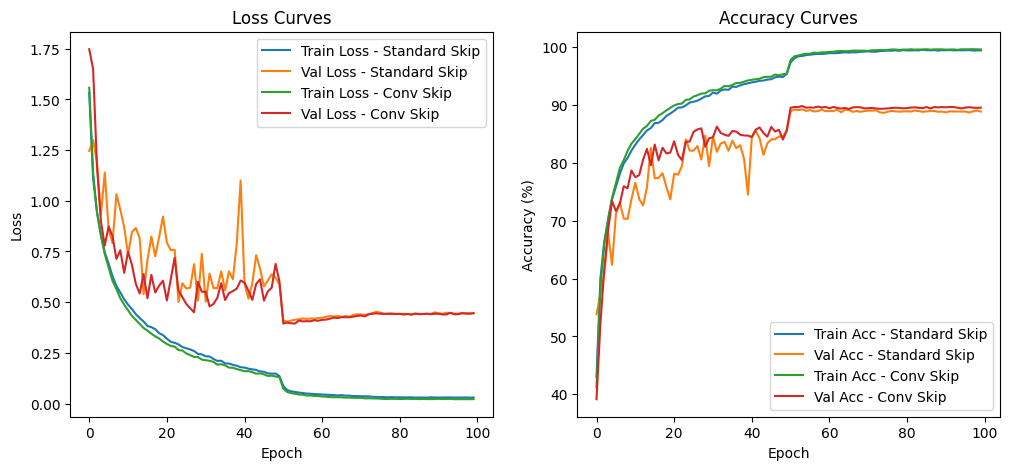

In [8]:
# Plot Loss Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses_standard, label='Train Loss - Standard Skip')
plt.plot(val_losses_standard, label='Val Loss - Standard Skip')
plt.plot(train_losses_conv, label='Train Loss - Conv Skip')
plt.plot(val_losses_conv, label='Val Loss - Conv Skip')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1,2,2)
plt.plot(train_accs_standard, label='Train Acc - Standard Skip')
plt.plot(val_accs_standard, label='Val Acc - Standard Skip')
plt.plot(train_accs_conv, label='Train Acc - Conv Skip')
plt.plot(val_accs_conv, label='Val Acc - Conv Skip')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params_standard = count_parameters(model_standard)
params_conv = count_parameters(model_conv)

print(f'Number of parameters (Standard Skip): {params_standard}')
print(f'Number of parameters (Conv Skip): {params_conv}')

# Compute FLOPs (approximate)
def compute_flops(model, input_size):
    from thop import profile
    input = torch.randn(1, 3, input_size, input_size).to(device)
    macs, params = profile(model, inputs=(input, ), verbose=False)
    return macs

flops_standard = compute_flops(model_standard, 32)
flops_conv = compute_flops(model_conv, 32)

print(f'FLOPs per forward pass (Standard Skip): {flops_standard}')
print(f'FLOPs per forward pass (Conv Skip): {flops_conv}')

Number of parameters (Standard Skip): 446410
Number of parameters (Conv Skip): 470986
FLOPs per forward pass (Standard Skip): 458228416.0
FLOPs per forward pass (Conv Skip): 483394240.0


In [12]:
import pandas as pd

# Function to calculate percentage difference
def calculate_percentage_difference(standard_values, conv_values):
    percentage_diff = []
    for s, c in zip(standard_values, conv_values):
        # Handle division by zero
        if s == 0:
            diff = float('inf')  # or 0, depending on context
        else:
            diff = ((c - s) / s) * 100
        percentage_diff.append(diff)
    return percentage_diff

# Collect metrics
metrics = [
    'Final Train Loss',
    'Final Val Loss',
    'Final Train Acc',
    'Final Val Acc',
    'Number of Parameters',
    'FLOPs per Forward Pass',
    'Total Training Time'
]

standard_values = [
    train_losses_standard[-1],
    val_losses_standard[-1],
    train_accs_standard[-1],
    val_accs_standard[-1],
    params_standard,
    flops_standard,
    sum(times_standard)
]

conv_values = [
    train_losses_conv[-1],
    val_losses_conv[-1],
    train_accs_conv[-1],
    val_accs_conv[-1],
    params_conv,
    flops_conv,
    sum(times_conv)
]

# Calculate percentage differences
percentage_diff = calculate_percentage_difference(standard_values, conv_values)

# Create DataFrame
data = {
    'Metric': metrics,
    'Standard Skip': standard_values,
    'Conv Skip': conv_values,
    'Percentage Difference (%)': percentage_diff
}

df = pd.DataFrame(data)

# Format floating-point numbers for readability
pd.options.display.float_format = '{:.2f}'.format

print(df)

                   Metric  Standard Skip    Conv Skip  \
0        Final Train Loss           0.03         0.02   
1          Final Val Loss           0.45         0.45   
2         Final Train Acc          99.39        99.56   
3           Final Val Acc          88.83        89.51   
4    Number of Parameters      446410.00    470986.00   
5  FLOPs per Forward Pass   458228416.00 483394240.00   
6     Total Training Time        1593.69      1657.42   

   Percentage Difference (%)  
0                     -27.18  
1                      -0.12  
2                       0.17  
3                       0.77  
4                       5.51  
5                       5.49  
6                       4.00  


In [11]:
# Example analysis
print("Analysis of Trade-offs:")
print("1. Performance:")
if val_accs_standard[-1] > val_accs_conv[-1]:
    print("- The Standard Skip Connection achieved higher validation accuracy.")
else:
    print("- The Conv Skip Connection achieved higher validation accuracy.")

print("2. Computational Efficiency:")
if params_standard < params_conv:
    print("- The Standard Skip Connection has fewer parameters.")
else:
    print("- The Conv Skip Connection has fewer parameters.")

if flops_standard < flops_conv:
    print("- The Standard Skip Connection requires fewer FLOPs per forward pass.")
else:
    print("- The Conv Skip Connection requires fewer FLOPs per forward pass.")

print("3. Training Time:")
if sum(times_standard) < sum(times_conv):
    print("- The Standard Skip Connection trained faster.")
else:
    print("- The Conv Skip Connection trained faster.")

Analysis of Trade-offs:
1. Performance:
- The Conv Skip Connection achieved higher validation accuracy.
2. Computational Efficiency:
- The Standard Skip Connection has fewer parameters.
- The Standard Skip Connection requires fewer FLOPs per forward pass.
3. Training Time:
- The Standard Skip Connection trained faster.
